Declining  Fertility Rates
Collaborators: John Iglesias

In [71]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 20000)


Introduction

The purpose of this project is to walk through a data science pipeline while 
exploring the world's fertility rate trends and its relationship with
global GDP (gross domestic output). Several countries around the globe have
experienced decreasing fertility rates for the past few decades which has
raised some ears

Data Processing

In [23]:

def getBirthRateData() -> pd.DataFrame:
    ''''returns df of every country's birth rate annually since 1970'''
    # Get a list of all country codes
    url = "http://api.worldbank.org/v2/country/all?per_page=500&format=json"
    response = requests.get(url)
    country_codes = [c['id'] for c in response.json()[1]]

    # Retrieve birth rate data for each country
    data = []
    for country_code in country_codes:
        url = f"http://api.worldbank.org/v2/country/{country_code}/indicator/SP.DYN.CBRT.IN"
        params = {
            "format": "json",
            "date": "1970:2020",
        }
        response = requests.get(url, params=params)
        response_json = response.json()
        # Check if the response is valid before iterating over it
        if len(response_json) > 1:
            if response_json[1]:
                for entry in response_json[1]:
                    data.append({
                        "country": entry["country"]["value"],
                        "date": entry["date"],
                        "birth_rate": entry["value"],
                    })

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data)
    return df


In [27]:
df = getBirthRateData()
df.head(10)

,country,date,birth_rate
0,Aruba,2020,8.102
1,Aruba,2019,9.138
2,Aruba,2018,9.881
3,Aruba,2017,11.530
4,Aruba,2016,12.300
5,Aruba,2015,12.428
6,Aruba,2014,13.533
7,Aruba,2013,13.316
8,Aruba,2012,12.723
9,Aruba,2011,12.246


In [74]:
def get_gdp_df():
    '''returns df of every country's gdp annually since 1970'''
    url = 'https://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD?per_page=20000&date=1970:2022&format=json'
    response = requests.get(url)

    # Extract JSON data from response
    data = response.json()
    df = pd.json_normalize(data[1])

    # get relevant columns
    df = df[['country.value', 'date', 'value']]
    
    # Rename columns
    df.columns = ['country', 'year', 'gdp']

    # Pivot the table to make years as columns
    df = df.pivot(index='country', columns='year', values='gdp')

    return df

gdp_df = get_gdp_df()
gdp_df












year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.748887e+09,1.831109e+09,1.595555e+09,1.733333e+09,2.155555e+09,2.366667e+09,2.555556e+09,2.953333e+09,3.300000e+09,3.697940e+09,...,2.020357e+10,2.056449e+10,2.055058e+10,1.999816e+10,1.801956e+10,1.889635e+10,1.841885e+10,1.890449e+10,2.014344e+10,1.478686e+10
Africa Eastern and Southern,4.486458e+10,4.948110e+10,5.351720e+10,6.960386e+10,8.606157e+10,9.165319e+10,9.112857e+10,1.034204e+11,1.153501e+11,1.346773e+11,...,9.720022e+11,9.826771e+11,1.003403e+12,9.231439e+11,8.898593e+11,1.030482e+12,1.016697e+12,1.009052e+12,9.341791e+11,1.089454e+12
Africa Western and Central,2.350461e+10,2.083282e+10,2.526495e+10,3.127382e+10,4.421448e+10,5.144473e+10,6.212939e+10,6.531501e+10,7.119971e+10,8.862840e+10,...,7.360399e+11,8.322169e+11,8.924979e+11,7.669580e+11,6.905454e+11,6.837480e+11,7.663597e+11,7.947191e+11,7.847997e+11,8.401873e+11
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.231983e+10,1.277622e+10,1.322815e+10,1.138685e+10,1.186120e+10,1.301969e+10,1.515643e+10,1.540183e+10,1.513187e+10,1.825579e+10
Algeria,4.863487e+09,5.077222e+09,6.766767e+09,8.707848e+09,1.321003e+10,1.555793e+10,1.772835e+10,2.097190e+10,2.636449e+10,3.324342e+10,...,2.090590e+11,2.097550e+11,2.138100e+11,1.659793e+11,1.600342e+11,1.700970e+11,1.749109e+11,1.717674e+11,1.450092e+11,1.630444e+11
American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.400000e+08,6.380000e+08,6.430000e+08,6.730000e+08,6.710000e+08,6.120000e+08,6.390000e+08,6.470000e+08,7.160000e+08,7.090000e+08
Andorra,7.861921e+07,8.940982e+07,1.134082e+08,1.508201e+08,1.865587e+08,2.201272e+08,2.272810e+08,2.540202e+08,3.080089e+08,4.115783e+08,...,3.188809e+09,3.193704e+09,3.271808e+09,2.789870e+09,2.896679e+09,3.000181e+09,3.218316e+09,3.155065e+09,2.891022e+09,3.330282e+09
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.249982e+11,1.334016e+11,1.372444e+11,8.721930e+10,4.984049e+10,6.897277e+10,7.779294e+10,6.930911e+10,5.361907e+10,6.740429e+10
Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.749675e+07,8.787934e+07,1.090800e+08,...,1.199948e+09,1.181448e+09,1.249733e+09,1.336693e+09,1.436585e+09,1.467978e+09,1.605944e+09,1.687533e+09,1.370281e+09,1.471126e+09


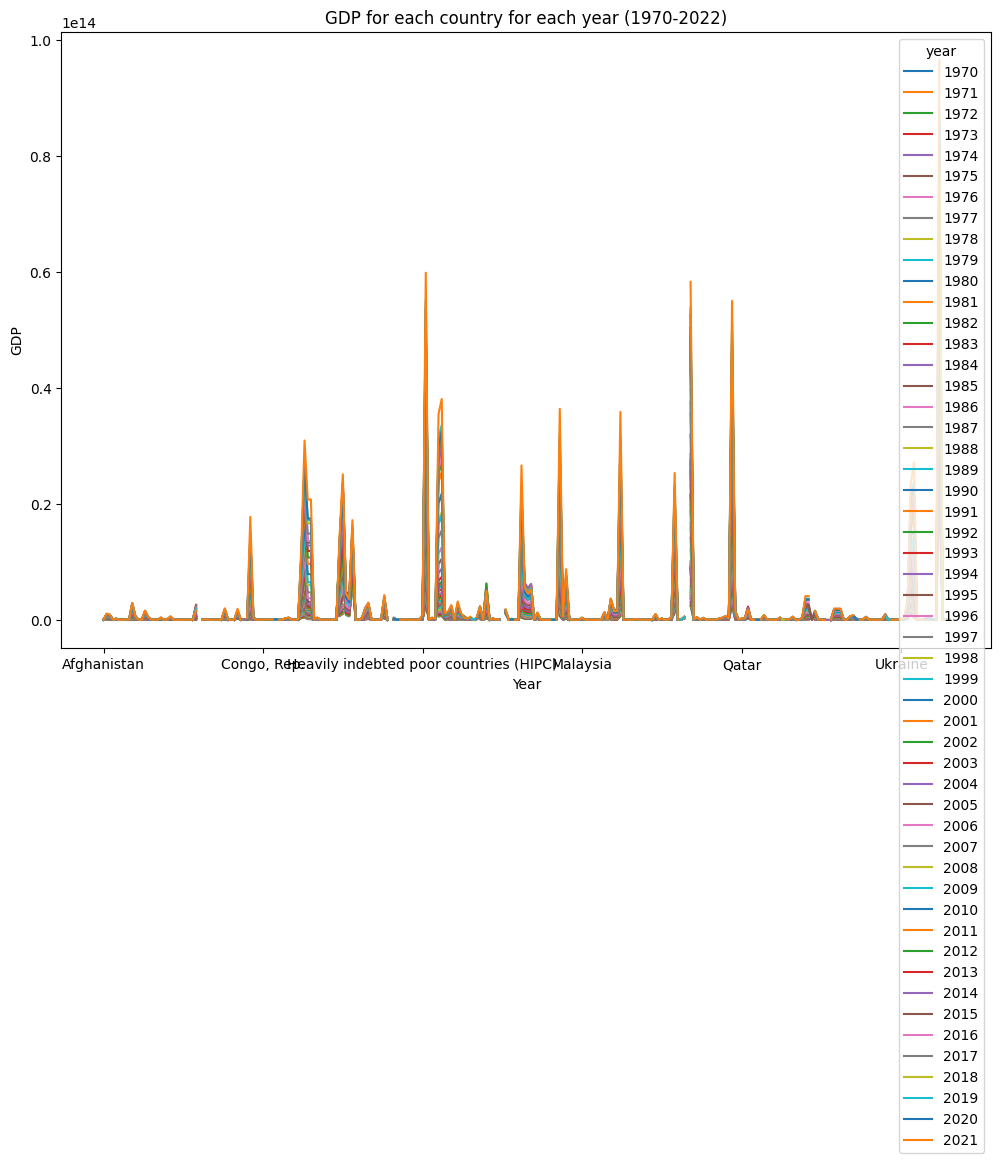